In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import cKDTree
from scipy.interpolate import RegularGridInterpolator, SmoothBivariateSpline, RectBivariateSpline
from scipy.optimize import minimize
import conduction
from time import clock

from petsc4py import PETSc
from mpi4py import MPI
comm = MPI.COMM_WORLD

In [2]:
directory = '/opt/ben/'

layer_attributes = np.loadtxt(directory+'layers.info', skiprows=1, usecols=(2,3,4,5,6,7,8,9,10))
layer_number = np.loadtxt(directory+'layers.info', dtype=int, skiprows=1, usecols=(0,))
layer_name   = np.loadtxt(directory+'layers.info', dtype=str, skiprows=1, usecols=(1,))

layer_header = ['body number', 'density', 'alpha', 'thermal conductivity', 'heat production rate',\
                'pressure coefficient', 'Gruneisen parameter', 'pressure derivative of bulk modulus', 'man']


layer = dict()
for i in xrange(0, 10):
    data = np.loadtxt(directory+'layers_xy/layer{}.xyz'.format(i))
    layer[i] = data

In [3]:
Xcoords = np.unique(data[:,0])
Ycoords = np.unique(data[:,1])

nx, ny = Xcoords.size, Ycoords.size

minX, minY, minZ = data.min(axis=0)
maxX, maxY, maxZ = data.max(axis=0)

# minZ = -400e3
minZ = -130e3
maxZ = 600.0

if comm.rank == 0:
    print("min/max:\n x {}\n y {}\n z {}".format((minX, maxX),
                                                 (minY, maxY),
                                                 (minZ, maxZ)))

min/max:
 x (350000.0, 788000.0)
 y (480000.0, 1000000.0)
 z (-130000.0, 600.0)


In [4]:
spl = dict()

for i in xrange(10):
    data = layer[i]
    xl = data[:,0]
    yl = data[:,1]
    zl = data[:,2].reshape(ny,nx)
    spl[i] = RectBivariateSpline(Ycoords, Xcoords, zl)


## Setup the hexahedral mesh

Nx, Ny, Nz = 55, 55, 105

mesh = conduction.ConductionND((minX, minY, minZ), (maxX, maxY, maxZ), (Nx, Ny, Nz))

coords = mesh.coords

Xcoords = np.unique(coords[:,0])
Ycoords = np.unique(coords[:,1])
Zcoords = np.unique(coords[:,2])

nz, ny, nx = mesh.n

In [5]:
## Fill the volume between each surface

xq, yq = np.meshgrid(Xcoords, Ycoords)
xq = xq.ravel()
yq = yq.ravel()

horizontal_slice = np.column_stack([xq, yq])


# create layer voxel
layer_voxel = np.zeros((nz, ny, nx), dtype=np.int8)
layer_mask = np.zeros(nx*ny*nz, dtype=bool)

# create KDTree
tree = cKDTree(coords)


def query_nearest(l):
    """
    Need to be careful in parallel -
     can't have a processor filling in a region off-processor
     (although it appears the shadow zones save us here)

    """
    layer_mask.fill(0)
    
    zq = spl[l].ev(yq, xq)
    d, idx = tree.query(np.column_stack([xq, yq, zq]))
    layer_mask[idx] = True
    
    return np.where(layer_mask.reshape(nz,ny,nx))

layer_voxel.fill(0)


for l in xrange(0,10):
    i0, j0, k0 = query_nearest(l)

    for i in xrange(i0.size):
        layer_voxel[:i0[i], j0[i], k0[i]] = l+1

    if comm.rank == 0:
        print("mapped layer {}".format(l))



# Fill everything above value
layer_voxel[layer_voxel > 9] = 9

mapped layer 0
mapped layer 1
mapped layer 2
mapped layer 3
mapped layer 4
mapped layer 5
mapped layer 6
mapped layer 7
mapped layer 8
mapped layer 9


In [6]:
# Boundary conditions
topBC = 298.0
bottomBC = 0.03

mesh.boundary_condition('maxZ', topBC, flux=False)
mesh.boundary_condition('minZ', bottomBC, flux=True)

inv = conduction.Inversion(layer_voxel.flatten(), mesh)

k = layer_attributes[:,2]
H = layer_attributes[:,3]
a = np.zeros_like(k)
q0 = 30e-3

# air + moho layer
layer_name = np.hstack([['Air'], layer_name, ['Moho']])
k = np.hstack([[3.5],k,[3.5]])
H = np.hstack([[0.0],H, [0.0]])
a = np.zeros_like(k)

for i, l in enumerate(inv.lithology_index):
    name = layer_name[i]
    ki = k[i]
    Hi = H[i]
    if comm.rank == 0:
        print('{:2} {:15} \t k = {}, H = {}'.format(l, name, ki, Hi))
        
x = PETSc.Vec().createWithArray(np.hstack([k, H, a, [40e-3]]))
dx = 0.01*x
gradient = x.duplicate()

 0 Air             	 k = 3.5, H = 0.0
 1 NewSer_Granit   	 k = 3.5, H = 4e-06
 2 Mafic_volc      	 k = 2.3, H = 5e-07
 3 upper_crust     	 k = 2.5, H = 1e-06
 4 lower_crust     	 k = 2.5, H = 1e-06
 5 Leinster        	 k = 5.3, H = 1e-08
 6 Mid_Valley      	 k = 5.3, H = 1e-08
 7 Connemara       	 k = 5.3, H = 1e-08
 8 Grampian        	 k = 5.3, H = 1e-08
 9 Moho            	 k = 3.5, H = 0.0


In [7]:
# Priors
k_prior = k.copy()
H_prior = H.copy()
a_prior = a.copy()

sigma_k = k*0.1
sigma_H = H*0.1
sigma_a = a*0.1

inv.add_prior(k=(k_prior,sigma_k), H=(H_prior,sigma_H), q0=(30e-3, 5e-3))

In [8]:
# Observations
brock_1989 = np.loadtxt('/opt/ben/Dropbox/GOTherm/data/Brock_1989_heat_flow.csv', delimiter=',', dtype=str, skiprows=1)

brock_ID  = brock_1989[:,1]
brock_lat = brock_1989[:,2].astype(float)
brock_lon = brock_1989[:,3].astype(float)
brock_HF  = brock_1989[:,9].astype(float) * 1e-3
brock_dHF = brock_HF*0.2

import benpy
brock_eastings, brock_northings = benpy.transform_coordinates(brock_lon, brock_lat, 4326, 2157)
brock_coord = np.zeros((brock_HF.size, 3))
brock_coord[:,0] = brock_eastings
brock_coord[:,1] = brock_northings

inv.add_observation(q=(brock_HF, brock_dHF, brock_coord[:,::-1]))

In [11]:
# Perturb around x
def misfit(x):
    cost = inv.forward_model(x)
    inv.mesh.dm.globalToLocal(inv.temperature, inv.mesh.lvec)
    T = inv.mesh.lvec.array.copy()
    k = inv.mesh.diffusivity[:]

    gradTz, gradTy, gradTx = inv.mesh.gradient(T)
    heatflux = -k.reshape(inv.mesh.n)*(gradTz + gradTy + gradTx)
    inv.interp.values = heatflux
    q_interp = inv.interp(brock_coord[:,::-1])
    
    return (q_interp - brock_HF)**2/brock_dHF**2 #(Q1_interp - HFdata.HF)**2

In [14]:
J = np.zeros((x.array.size, brock_HF.size)) # Jacobian matrix
fm0 = misfit(x)

for i in xrange(x.size):
    dx.set(0.0)
    dx[i] += x[i]*0.01
    fm1 = misfit(x+dx)
    
    J[i] = fm1 - fm0
    print("{:2} change in cost = {}".format(i, fm1.sum() - fm0.sum()))

 0 change in cost = 0.170296456596
 1 change in cost = -0.0108770047211
 2 change in cost = 0.00952737183716
 3 change in cost = -0.152764556735
 4 change in cost = -0.00763354923136
 5 change in cost = -0.0288248675847
 6 change in cost = 0.0146681431287
 7 change in cost = 0.0600106018298
 8 change in cost = -0.0421680536293
 9 change in cost = -0.0104768892627
10 change in cost = 0.0
11 change in cost = 0.00111531460853
12 change in cost = -0.000363728846018
13 change in cost = 0.382842764277
14 change in cost = 0.180584276515
15 change in cost = 0.00540650262759
16 change in cost = 0.0015018616164
17 change in cost = 0.00377817921404
18 change in cost = 0.00121887253188
19 change in cost = 0.0
20 change in cost = 0.0
21 change in cost = 0.0
22 change in cost = 0.0
23 change in cost = 0.0
24 change in cost = 0.0
25 change in cost = 0.0
26 change in cost = 0.0
27 change in cost = 0.0
28 change in cost = 0.0
29 change in cost = 0.0
30 change in cost = 0.765405750508


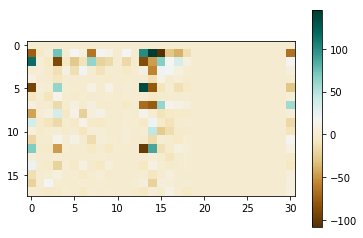

In [17]:
Jinv = np.linalg.pinv(J)
Rm = Jinv*J.T

plt.imshow(Rm, interpolation='nearest', cmap='BrBG')
plt.colorbar()

In [18]:
size = len(inv.lithology_index)

Jk = J.T[:,1:size]
JH = J.T[:,size+1:2*size]
Ja = J.T[:,2*size+1:3*size]
JQ0 = J.T[:,-1]

# order = [3, 4, 6, 5, 7, 8, 9, 0, 1, 2, 10, 11]

# Jk = Jk[:,order]
# JH = JH[:,order]
# Ja = Ja[:,order]

JT = np.hstack([Jk, JH, Ja, JQ0.reshape(-1,1)])
# for row in xrange(JT.shape[0]):
#     JT[row,:] *= sigma_x
# for col in xrange(JT.shape[1]):
#     JT[:,col] /= HFdata.HFerror

# J2 = (JT-JT.min())/(JT.max()-JT.min())
# J2 *= 2.0
# J2 -= 1.0
Jsum = np.abs(JT).sum(axis=0)
J2 = np.abs(JT)
J2 /= (J2.max()-J2.min())

In [57]:
J2 = J / fm0
J2[np.isnan(J2)] = 0

Jk = J2.T[:,1:size]
JH = J2.T[:,size+1:2*size]
Ja = J2.T[:,2*size+1:3*size]
JQ0 = J2.T[:,-1]

JT = np.hstack([Jk, JH, Ja, JQ0.reshape(-1,1)])
Jsum = np.abs(JT).sum(axis=0)

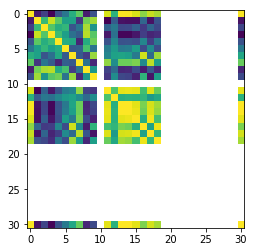

In [56]:
plt.imshow(np.corrcoef(J))

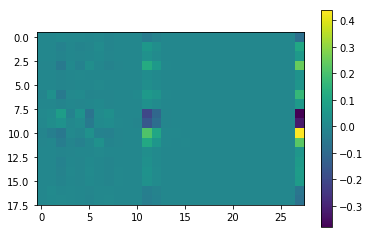

In [53]:
plt.imshow(JT)
plt.colorbar()

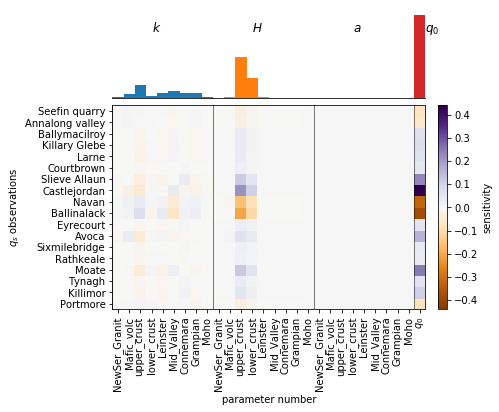

In [93]:
from matplotlib.gridspec import GridSpec

colours = {'k': '#4B0082', 'H': '#FF0000', 'a': '#FFD700', '\psi':'b', 'B':'brown', 'Q0': '#008000'}
facecolours = ['0.9', '0.99', '0.9']

start = 0
split = Jsum.size // 3

fig = plt.figure(1, figsize=(6,5.5))

gs = GridSpec(2,2, hspace=0.05, wspace=0.075, width_ratios=[0.97,0.03], height_ratios=[0.3, 0.7])

ax1 = fig.add_subplot(gs[0,0])
# ax1.axis('off')

for i, param in enumerate(['k', 'H', 'a']):
    ax1.bar(np.arange(start,start+split)+0.5, Jsum[start:start+split], 1, label='$'+param+'$', zorder=2)
    ax1.text(start+split/2-0.5, Jsum.max()-0.2*Jsum.max(), '$'+param+'$', size=12)
    start += split

    
ax1.bar(start+0.5, Jsum[-1], 1, label='$q_0$')
ax1.text(start+1, Jsum.max()-0.2*Jsum.max(), '$q_0$', size=12)

# ax1.legend(loc='upper center', ncol=4, frameon=False)
ax1.set_xlim([0,start+1])
# ax1.set_xlabel('parameter number')
# ax1.set_ylabel('% improvement')
for spine in ['right', 'top', 'left']:
    ax1.spines[spine].set_visible(False)
ax1.tick_params(axis='x', which='both', top='off', bottom='off')
ax1.tick_params(axis='y', which='both', left='on', right='off')
ax1.set_xticks([])
ax1.set_yticks([])
# ax1.set_yticks(np.arange(0,25,5))

vmax = np.abs(JT).max()
ax2 = fig.add_subplot(gs[1,0], xlim=[0,Jsum.size], ylim=[0,brock_HF.size])
im2 = ax2.pcolor(JT, cmap='PuOr', vmin=-vmax, vmax=vmax)
start = 0
for i in xrange(4):
    ax2.plot([start,start], [0, brock_HF.size], c='0.0', linestyle='solid', linewidth=0.5)
    start += split
    
xticks = ax2.get_xticks()[:-1]
plt.xticks(np.arange(parameter_names.size)+0.5, parameter_names, rotation='vertical')
plt.yticks(np.arange(brock_ID.size)+0.5, brock_ID)

ax2.set_xlabel('lithology')
ax2.set_ylabel('$q_s$ observations')

ax4 = fig.add_subplot(gs[1,1])
cb = fig.colorbar(im2, ax=ax2, cax=ax4)
ax4.set_ylabel('sensitivity')

plt.savefig('normalised_jacobian.pdf', bbox_inches='tight')

In [74]:
parameter_names = np.hstack([layer_name[1:], layer_name[1:], layer_name[1:], [r'$q_0$']])